In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from sklearnex import patch_sklearn
patch_sklearn()
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from IPython.display import clear_output
import shap


import warnings
warnings.filterwarnings("ignore")
from src.constants import CLEANED_HOUSEHOLD_POWER_PATH, CLEANED_WEATHER_PATH, \
    HOUSEHOLD_WEATHER_MERGED_PATH

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Hourly distribution

In [3]:
df = pd.read_pickle(
    HOUSEHOLD_WEATHER_MERGED_PATH    
)

house_consumpion_columns = [
    'global_active_power', 
    'global_reactive_power', 
    'voltage',
    'global_intensity', 
    'sub_metering_1', 
    'sub_metering_2',
    'sub_metering_3',
    'daily_energy_consumption_kwh'
]

df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,numer_sta,pmer,tend,...,phenspe1,phenspe2,phenspe3,nnuage1,ctype1,hnuage1,Nom,Latitude,Longitude,Altitude
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,1017.0,710.0,1118.0,2.0,8.0,780.0,ORLY,48.716833,2.384333,89.0


In [4]:
df.shape

(2053263, 43)

## Train test split

In [5]:

def get_season(x):
    seasons = []
    month = x.month
    
    for m in month:
    # Define the seasons based on months
        if 3 <= m <= 5:
            season = "Spring"
        elif 6 <= m <= 8:
            season = "Summer"
        elif 9 <= m <= 11:
            season = "Autumn"
        else:
            season = "Winter"

        seasons.append(season)

    return seasons


In [6]:
def get_weekend_feature(df:pd.DataFrame):
    day_of_week = df.index.day_of_week
    is_weekend = (day_of_week == 5) | (day_of_week ==6)
    df['is_weekend'] = is_weekend.astype(float)

    return df

def get_season_feature(df : pd.DataFrame):
    seasons = get_season(df.index)
    df['season'] = seasons
    df = pd.concat(
        [
            df,
            pd.get_dummies(df['season'])
        ],
        axis = 1
    )

    return df



In [7]:
raw_train_df = df.loc[:'31-12-2009']
raw_test_df = df.loc['2010']

# ------------ train df -------------------------------

raw_train_df['daily_energy_consumption_kwh'] = raw_train_df['global_active_power']\
    .groupby(
        pd.Grouper(freq='1D')
    ).sum()/(60)

train_df = raw_train_df.dropna()

train_df = get_weekend_feature(train_df)
train_df = get_season_feature(train_df)


# ------------ test df ----------------------------------

raw_test_df['daily_energy_consumption_kwh'] = raw_test_df['global_active_power']\
    .groupby(
        pd.Grouper(freq='1D')
    ).sum()/(60)

test_df = raw_test_df.dropna()

test_df = get_weekend_feature(test_df)
test_df = get_season_feature(test_df)


In [8]:
train_df

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3,numer_sta,pmer,tend,...,Latitude,Longitude,Altitude,daily_energy_consumption_kwh,is_weekend,season,Autumn,Spring,Summer,Winter
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,2.580,0.136,241.97,10.6,0.0,0.0,0.0,7149.0,101960.0,-70.0,...,48.716833,2.384333,89.0,45.816733,0.0,Winter,0,0,0,1
2007-01-02,0.442,0.122,241.06,1.8,0.0,0.0,0.0,7149.0,102090.0,430.0,...,48.716833,2.384333,89.0,21.153933,0.0,Winter,0,0,0,1
2007-01-03,1.372,0.058,244.95,5.6,0.0,0.0,0.0,7149.0,103310.0,130.0,...,48.716833,2.384333,89.0,16.784167,0.0,Winter,0,0,0,1
2007-01-04,0.850,0.046,242.61,3.6,0.0,0.0,0.0,7149.0,102060.0,-310.0,...,48.716833,2.384333,89.0,51.708667,0.0,Winter,0,0,0,1
2007-01-05,1.172,0.182,243.62,4.8,0.0,0.0,0.0,7149.0,102360.0,120.0,...,48.716833,2.384333,89.0,44.316100,0.0,Winter,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-27,1.468,0.062,245.51,6.0,0.0,0.0,19.0,7149.0,100850.0,-30.0,...,48.716833,2.384333,89.0,35.322750,1.0,Winter,0,0,0,1
2009-12-28,0.452,0.116,246.06,1.8,0.0,0.0,1.0,7149.0,100960.0,20.0,...,48.716833,2.384333,89.0,34.649167,0.0,Winter,0,0,0,1
2009-12-29,0.298,0.000,242.80,1.2,0.0,0.0,1.0,7149.0,99970.0,-200.0,...,48.716833,2.384333,89.0,33.101867,0.0,Winter,0,0,0,1


### Selecting columns

In [9]:

corr = train_df.corr()

In [10]:
abs(corr.loc['daily_energy_consumption_kwh']).sort_values().dropna().tail(10)

is_weekend                      0.210917
voltage                         0.219509
vv                              0.252911
global_intensity                0.307689
global_active_power             0.317318
Winter                          0.416461
td                              0.473088
t                               0.512941
Summer                          0.517790
daily_energy_consumption_kwh    1.000000
Name: daily_energy_consumption_kwh, dtype: float64

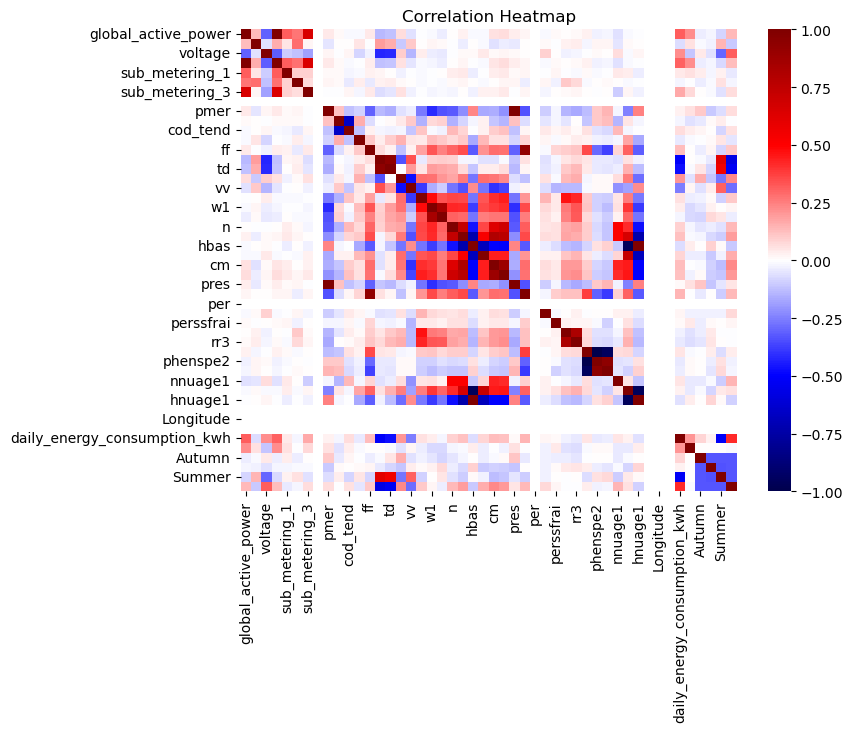

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

## Selecting features

In [36]:
selected_columns = corr['global_active_power'].abs() > 1e-1
selected_columns[house_consumpion_columns] = False
selected_columns = selected_columns[selected_columns].index

selected_columns

Index(['t', 'td', 'is_weekend', 'Winter'], dtype='object')

## Optimization methods

### Choosing model- cross validation

In order to determine the optimal model for testing, we will train various models and select the one that demonstrates the highest average performance during the validation period.

In [37]:

def train(
    train_df : pd.DataFrame, 
    target: pd.Series,
    n_splits : int,
    models : List[BaseEstimator] = [
        SVR(kernel = 'rbf'), 
        LinearRegression(), 
        Lasso(), 
        DecisionTreeRegressor(max_depth = 4),
        RandomForestRegressor(n_estimators = 30, max_depth = 4), 
    ]
):
    """
    Train multiple regression models and evaluate their performance using cross-validation.

    Parameters:
    - train_df (pd.DataFrame): DataFrame containing the training features.
    - target (pd.Series): Series containing the target variable.
    - n_splits (int): Number of splits for cross-validation.
    - models (List[BaseEstimator], optional): List of regression models to train. Defaults to a list containing SVR, LinearRegression, Lasso, RandomForestRegressor, and MLPRegressor.

    Returns:
    - results (Dict[str, List[float]]): Dictionary containing the validation scores for each model.
    """
    
    results = {type(x).__name__ : [] for x in models}
    splitter = splitter = KFold(n_splits)

    for model in models:

        model_name : str = type(model).__name__
        
        clear_output()
        print(f"Running model selection for {model_name}")

        splits = splitter.split(train_df)

        for idx_train, idx_val in tqdm(splits, total = n_splits):
            X_train = train_df.iloc[idx_train]
            y_train = target.iloc[idx_train]

            X_val = train_df.iloc[idx_val]
            y_val = target.iloc[idx_val]

            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)

            validation_score = r2_score(y_val, y_pred)

            results[model_name].append(validation_score)

    return results

In [44]:
selected_columns = [
       'is_weekend', 'Autumn', 'Spring', 'Summer', 'Winter'
]

In [45]:

X_train = train_df[selected_columns]\
    .dropna()

y_train = train_df['daily_energy_consumption_kwh']

intersection_idx = y_train.index.intersection(X_train.index)

y_train = y_train.reindex(index = intersection_idx)
X_train = X_train.reindex(index = intersection_idx)

# ----------- test ---------------------

X_test = test_df[selected_columns].dropna()
y_test = test_df['daily_energy_consumption_kwh']
intersection_idx = y_test.index.intersection(X_test.index)

y_test = y_test.reindex(index = intersection_idx)
X_test = X_test.reindex(index = intersection_idx)

In [84]:

train_results = train(
    X_train,
    y_train,
    5
)

Running model selection for RandomForestRegressor


100%|██████████| 5/5 [00:00<00:00, 26.78it/s]


In [85]:
pd.DataFrame(train_results)

,SVR,LinearRegression,Lasso,DecisionTreeRegressor,RandomForestRegressor
0,0.320613,0.322269,0.165152,0.328735,0.331185
1,0.298765,0.290210,0.085132,0.298336,0.299591
2,0.325247,0.320189,0.100582,0.331128,0.328373
3,0.055923,0.033824,-0.040762,0.046042,0.049171
4,0.519526,0.543440,0.322881,0.518033,0.510760


In [86]:
pd.DataFrame(train_results).mean()

SVR                      0.304015
LinearRegression         0.301986
Lasso                    0.126597
DecisionTreeRegressor    0.304455
RandomForestRegressor    0.303816
dtype: float64

## CHANGE HERE

As observed, weather features alone did not perform well during validation, as indicated by negative r2 scores. We will enhance them by incorporating features derived from previous target values.

## Experiment 2 - consumption features

In [139]:
frequencies = [1, 7]

X_train2 = X_train.copy()
y_train2 = y_train.copy()

X_test2 = X_test.copy()
y_test2 = y_test.copy()

for freq in frequencies:
    X_train2[f'avg_consumption_d-{freq}'] = y_train2.rolling(freq)\
        .mean()\
        .shift(1)
    
    X_train2[f'diff_consumption_d-{freq}'] = y_train2.diff(freq)\
        .shift(1)
    
    X_test2[f'avg_consumption_d-{freq}'] = y_test2.rolling(freq)\
        .mean()\
        .shift(1)
    
    X_test2[f'diff_consumption_d-{freq}'] = y_test2.diff(freq)\
        .shift(1)
    
X_train2 = X_train2.dropna()
y_train2 = y_train2.reindex(index = X_train2.index)

X_test2 = X_test2.dropna()
y_test2 = y_test2.reindex(index = X_test2.index)

# 

In [140]:
X_train2.corrwith(y_train2)

is_weekend              0.216206
Autumn                  0.084846
Spring                  0.029050
Summer                 -0.519147
Winter                  0.412174
avg_consumption_d-1     0.629710
diff_consumption_d-1    0.154342
avg_consumption_d-7     0.677523
diff_consumption_d-7    0.221487
dtype: float64

In [141]:
X_train2

,is_weekend,Autumn,Spring,Summer,Winter,avg_consumption_d-1,diff_consumption_d-1,avg_consumption_d-7,diff_consumption_d-7
date,,,,,,,,,
2007-01-09,0.0,0,0,0,1,37.336483,0.848200,33.113852,-8.480250
2007-01-10,0.0,0,0,0,1,29.651267,-7.685217,34.327757,8.497333
2007-01-11,0.0,0,0,0,1,34.787567,5.136300,36.899671,18.003400
2007-01-12,0.0,0,0,0,1,35.615733,0.828167,34.600681,-16.092933
2007-01-13,1.0,0,0,0,1,24.077333,-11.538400,31.709429,-20.238767
...,...,...,...,...,...,...,...,...,...
2009-12-27,1.0,0,0,0,1,35.973950,0.793283,31.242590,-0.378917
2009-12-28,0.0,0,0,0,1,35.322750,-0.651200,33.582450,16.379017
2009-12-29,0.0,0,0,0,1,34.649167,-0.673583,34.028455,3.122033


In [142]:
model = LinearRegression().fit(X_train2, y_train2)

In [143]:
explainer = shap.LinearExplainer(model, X_train2)


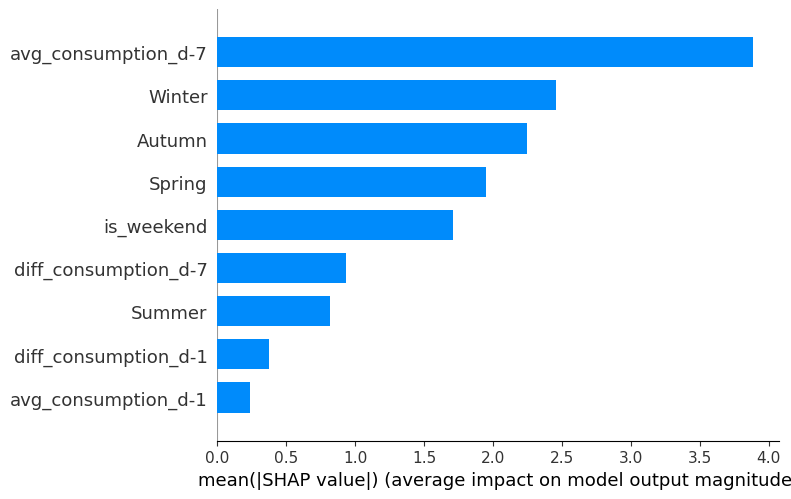

In [144]:
shap.summary_plot(explainer.shap_values(X_train2), X_train2, plot_type="bar")

In [145]:
X_train2

,is_weekend,Autumn,Spring,Summer,Winter,avg_consumption_d-1,diff_consumption_d-1,avg_consumption_d-7,diff_consumption_d-7
date,,,,,,,,,
2007-01-09,0.0,0,0,0,1,37.336483,0.848200,33.113852,-8.480250
2007-01-10,0.0,0,0,0,1,29.651267,-7.685217,34.327757,8.497333
2007-01-11,0.0,0,0,0,1,34.787567,5.136300,36.899671,18.003400
2007-01-12,0.0,0,0,0,1,35.615733,0.828167,34.600681,-16.092933
2007-01-13,1.0,0,0,0,1,24.077333,-11.538400,31.709429,-20.238767
...,...,...,...,...,...,...,...,...,...
2009-12-27,1.0,0,0,0,1,35.973950,0.793283,31.242590,-0.378917
2009-12-28,0.0,0,0,0,1,35.322750,-0.651200,33.582450,16.379017
2009-12-29,0.0,0,0,0,1,34.649167,-0.673583,34.028455,3.122033


In [216]:
results_experiment2 = train(
    X_train2,
    y_train2,
    5,
    models= [
        SVR(kernel = 'rbf'), 
        LinearRegression(), 
        Lasso(),
        DecisionTreeRegressor(max_depth = 5),
        RandomForestRegressor(n_estimators = 10, max_depth = 4), 
    ]
)

Running model selection for RandomForestRegressor


100%|██████████| 5/5 [00:00<00:00, 36.27it/s]


In [217]:
pd.DataFrame(results_experiment2)

,SVR,LinearRegression,Lasso,DecisionTreeRegressor,RandomForestRegressor
0,0.379443,0.486190,0.415109,0.361423,0.485062
1,0.372458,0.461400,0.429441,0.373798,0.406121
2,0.559928,0.639979,0.615886,0.468572,0.549854
3,0.134137,0.238856,0.158419,0.061629,0.196498
4,0.592015,0.632244,0.575248,0.429746,0.583315


In [218]:
pd.DataFrame(results_experiment2).mean()

SVR                      0.407596
LinearRegression         0.491734
Lasso                    0.438821
DecisionTreeRegressor    0.339034
RandomForestRegressor    0.444170
dtype: float64

In [219]:
model = LinearRegression()
model.fit(X_train2, y_train2)

SyntaxError: invalid syntax (995312367.py, line 1)

In [201]:
y_pred = model.predict(X_test2)

In [202]:
r2_score(y_test2, y_pred)

0.1163896419016266

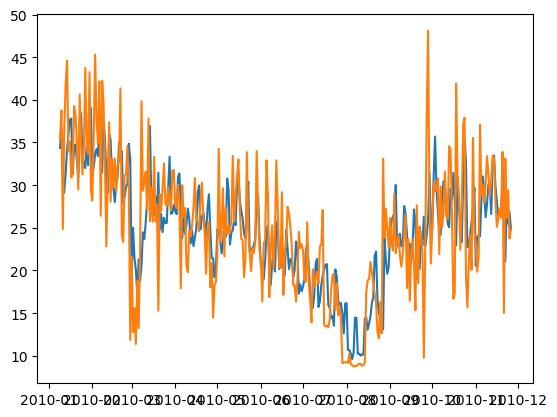

In [153]:
plt.plot(pd.Series(y_pred, index = y_test2.index))
plt.plot(y_test2)

## LSTM

In [154]:
X_train3 = X_train2.loc[:'2008']
y_train3 = y_train2.loc[:'2008']


In [155]:
X_val3 = X_train2.loc['2009':]
y_val3 = y_train2.loc['2009':]

In [172]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from torcheval.metrics import R2Score
metric = R2Score()

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Prepare the data
# Assuming X is a DataFrame and y is a Series
X_tensor = torch.tensor(X_train3.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train3.values, dtype=torch.float32).view(-1, 1)

X_tensor_val = torch.tensor(X_train3.values, dtype=torch.float32)
y_tensor_val = torch.tensor(y_train3.values, dtype=torch.float32).view(-1, 1)

# Define hyperparameters
input_size = X_train2.shape[1]  # Number of features
hidden_size = 2
num_layers = 2
output_size = 1  # Assuming y is a single output
batch_size = 1
num_epochs = 100
learning_rate = 0.001

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
val_dataset = TensorDataset(X_tensor_val, y_tensor_val)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs)):
    predictions = torch.Tensor([])
    y_true = torch.Tensor([])
    for batch_X, batch_y in data_loader:
        # Forward pass
        outputs = model(batch_X.unsqueeze(1))
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for X, y in val_data_loader:
        y_pred = model(X.unsqueeze(1))
        predictions = torch.concat([y_pred, predictions])
        y_true = torch.concat([y_true, y])

    metric.update(predictions, y_true)
    r2 = metric.compute()

    if (epoch+1) % 1 == 0:
        clear_output()
        print(f'Epoch [{epoch+1}/{num_epochs}], R2: {r2.item():.4f}')

100%|██████████| 100/100 [04:05<00:00,  2.45s/it]

Epoch [100/100], R2: -0.3449
